In [52]:
! git lfs install

Git LFS initialized.


In [53]:
! git clone https://github.com/timojl/clipseg

fatal: destination path 'clipseg' already exists and is not an empty directory.


In [54]:
! pip install diffusers -q

In [55]:
! pip install transformers -q -UU ftfy gradio

In [56]:
! pip install git+https://github.com/openai/CLIP.git -q

  Preparing metadata (setup.py) ... done


In [87]:
!pip install opencv-python

In [57]:
from huggingface_hub import notebook_login

notebook_login()

In [58]:
%cd clipseg

/content/clipseg


In [59]:
! ls

clip_masking_lvis_image_ids.yml  init_image.png    sample_rd64.png
clipseg				 __init__.py	   sample_rd64_refined.png
datasets			 LICENSE	   score.py
environment.yml			 metrics.py	   setup.py
evaluation_utils.py		 models		   supplementary.pdf
example_image.jpg		 overview.png	   Tables.ipynb
experiments			 Quickstart.ipynb  training.py
general_utils.py		 README.md	   Visual_Feature_Engineering.ipynb


In [60]:
import torch
import requests
import cv2
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

In [61]:
from io import BytesIO

from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

In [62]:
#! git lfs install

In [63]:
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();


In [64]:
# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('/content/rd64-uni.pth', map_location=torch.device('cuda')), strict=False);


<ipython-input-64-0a6a6ca20761>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/rd64-uni.pth', map_location=torch.device('cuda'))

In [65]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionInpaintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [66]:
# or load from URL...
image_url = 'https://okmagazine.ge/wp-content/uploads/2021/04/00-promo-rob-pattison-1024x1024.jpg' #'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimage.tmdb.org%2Ft%2Fp%2Foriginal%2F72xYNWRTVMDiKVa6SVu6EY0S9Np.jpg' #'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png'
input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

In [67]:
%cd ..

/content


In [68]:
input_image.convert("RGB").resize((512, 512)).save("init_image.png", "PNG")

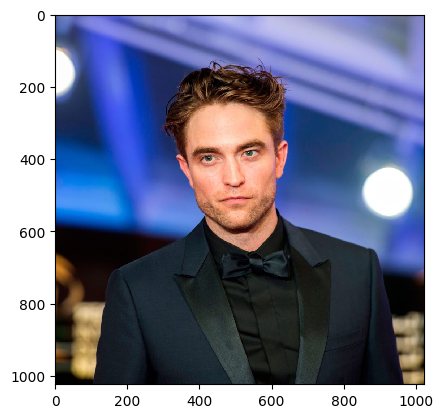

In [69]:
from matplotlib import pyplot as plt
plt.imshow(input_image, interpolation='nearest')
plt.show()

In [70]:
prompts = ['shirt']

In [71]:

# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]


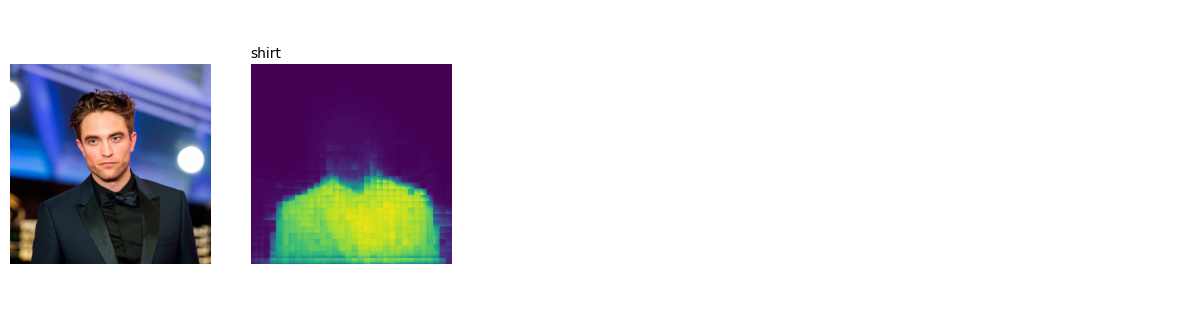

In [72]:
# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

In [73]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

In [74]:
img2 = cv2.imread(filename)

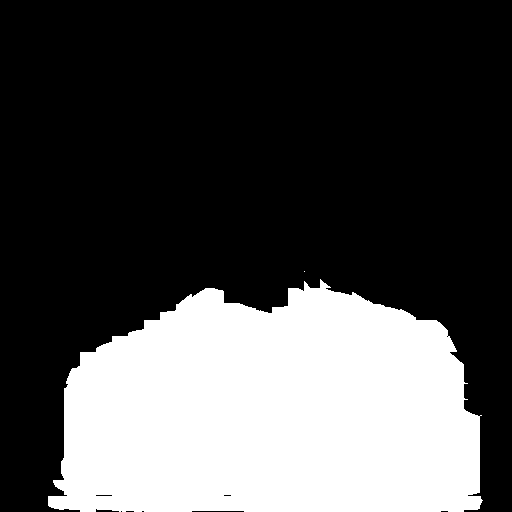

In [75]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

In [89]:
from PIL import Image
import cv2

In [90]:
init_image = torch.tensor(cv2.imread('init_image.png'))
mask = torch.tensor(cv2.imread('mask.png'))

In [91]:
init_image

tensor([[[141, 106,  96],
         [144, 108,  98],
         [150, 111,  99],
         ...,
         [199, 133, 126],
         [201, 133, 128],
         [201, 132, 129]],

        [[140, 104,  94],
         [143, 106,  95],
         [150, 110,  97],
         ...,
         [199, 133, 126],
         [201, 133, 128],
         [201, 133, 129]],

        [[140, 101,  89],
         [144, 103,  91],
         [150, 108,  95],
         ...,
         [200, 134, 127],
         [202, 134, 129],
         [202, 133, 130]],

        ...,

        [[  3,   1,   1],
         [  3,   1,   1],
         [  3,   1,   1],
         ...,
         [ 42,  97, 128],
         [ 36,  88, 120],
         [ 30,  80, 112]],

        [[  3,   1,   1],
         [  3,   1,   1],
         [  3,   1,   1],
         ...,
         [ 33,  83, 112],
         [ 28,  75, 106],
         [ 23,  70, 101]],

        [[  3,   1,   1],
         [  3,   1,   1],
         [  3,   1,   1],
         ...,
         [ 20,  67,  95],
        

In [92]:
print(type(init_image))
print(type(mask))
with autocast("cuda"):
    images = pipe(prompt="a yellow flowered holiday shirt", init_image=init_image, mask_image=mask, strength=0.8)["sample"]


<class 'torch.Tensor'>
<class 'torch.Tensor'>


ValueError: Input is in incorrect format. Currently, we only support <class 'PIL.Image.Image'>, <class 'numpy.ndarray'>, <class 'torch.Tensor'>

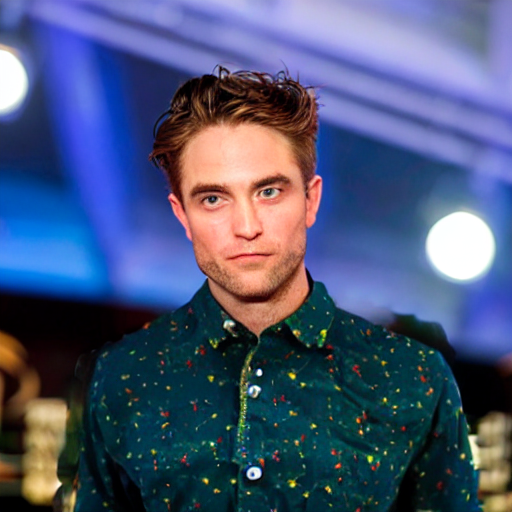

In [ ]:
images[0]